# Optimization of Insurance Services and Customer Data Protection

The insurance company Sure Tomorrow wants to solve several tasks using machine learning and asks you to evaluate this possibility.
- Task 1: Find customers who are similar to a specific customer. This will help the company's agents with marketing.
- Task 2: Predict the probability that a new customer will receive an insurance benefit. Can a predictive model perform better than a dummy model?
- Task 3: Predict the number of insurance benefits that a new customer may receive using a linear regression model.
- Task 4: Protect customers' personal data without affecting the previous exercise's model. It is necessary to develop a data transformation algorithm that makes it difficult for personal information to be recovered if it falls into the wrong hands. This is called data masking or obfuscation. However, the data must be protected in such a way that it does not affect the quality of machine learning models. It is not necessary to choose the best model; just demonstrate that the algorithm works correctly.

# Initialization

In [44]:
# Load libraries

# Data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math

# Modeling
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

# Visualization
import seaborn as sns

# Display
from IPython.display import display


# Load data

In [45]:
# Load the data into DataFrames
df = pd.read_csv('../datasets/insurance_us.csv')

# Prepare data

In [46]:
# Rename columns
df = df.rename(
    columns={
        'Gender': 'gender',
        'Age': 'age',
        'Salary': 'income',
        'Family members': 'family_members',
        'Insurance benefits': 'insurance_benefits',
    }
)

In [47]:
# Print the general/summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [48]:
# Print a random sample of 10 rows from the DataFrame
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1965,1,39.0,19900.0,1,0
1310,0,30.0,24700.0,1,0
4361,1,20.0,34100.0,0,0
1597,1,29.0,48300.0,0,0
4165,0,40.0,36500.0,1,0
2784,1,25.0,44300.0,0,0
1703,1,34.0,23500.0,3,0
784,0,42.0,47000.0,2,0
4168,1,22.0,34500.0,2,0
2180,0,39.0,51200.0,2,0


In [49]:
# Change the data type of age (from float to int)
df['age'] = df['age'].astype('int')

# Make sure the change has been applied
df['age'].dtype

dtype('int64')

In [50]:
# Take a look at the descriptive statistics of the data
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


### Intermediate conclusion

Overall, the dataset appears to have no missing values, outliers, or unusual data.

## Exploratory data analysis

We are going to quickly check if certain customer groups exist by observing the scatter plot.

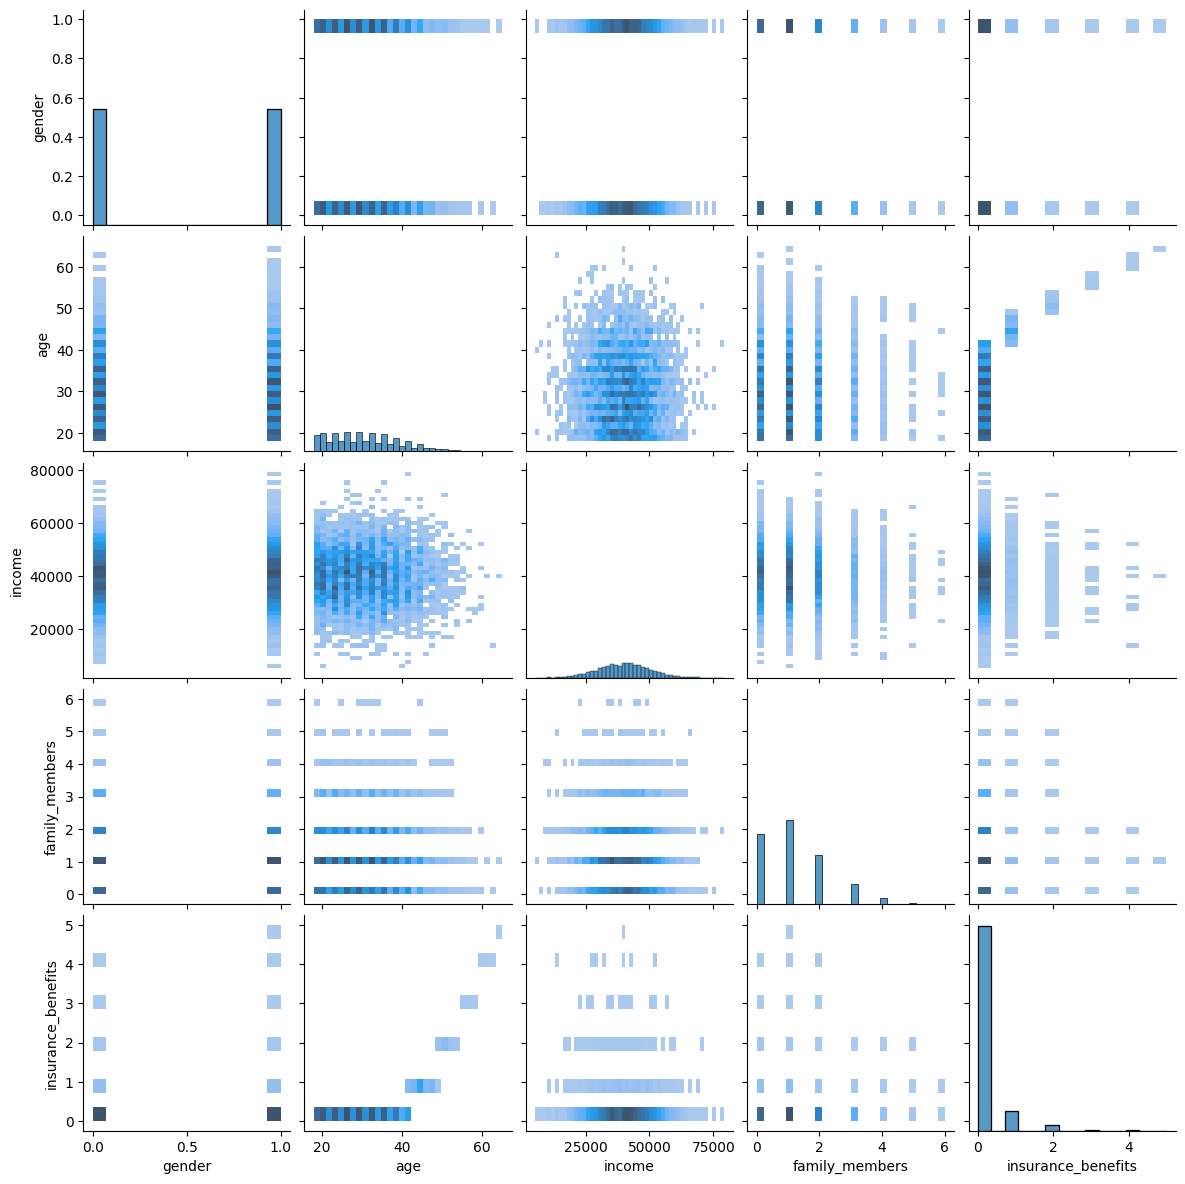

In [51]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

# Task 1. Similar Clients

In [52]:
# Create a list of features
feature_names = ['gender', 'age', 'income', 'family_members']

In [53]:
# Create a function to get the KNN (k-nearest neighbors)
def get_knn(df, n, k, metric):
    """
    Finds the k nearest neighbors of the nth object in a pandas DataFrame.

    Parameters:
        df: pandas DataFrame used to find similar objects within the same location
        n: Index of the object for which to find the nearest neighbors
        k: Number of nearest neighbors to return
        metric: Name of the distance metric

    Returns:
        pandas DataFrame with the k nearest neighbors
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)

    return pd.concat(
        [
            df.iloc[nbrs_indices[0]],
            pd.DataFrame(
                nbrs_distances.T, index=nbrs_indices[0], columns=['distance']
            ),
        ],
        axis=1,
    )

## Scaling data

In [54]:
# MaxAbsScaler transformation
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

# Transform the chosen features
df_scaled = df.copy()
df_scaled[feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [55]:
# Print a random sample of 5 rows from the DataFrame
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3057,1.0,0.507692,0.486076,0.333333,0
3884,0.0,0.400000,0.612658,0.500000,0
4264,1.0,0.646154,0.665823,0.000000,1
3480,0.0,0.369231,0.675949,0.166667,0
852,1.0,0.523077,0.443038,0.166667,0


## KNN (k-nearest neighbors)

In [56]:
# Get the 5 nearest neighbors for the object with index 0 (the first object)
k = 5
index = 0

In [57]:
# Using the Euclidean distance and non-scaled data
get_knn(df, index, k, 'euclidean')

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.000000
2022,1,41,49600.0,0,0,1.000000
1225,0,42,49600.0,0,1,1.732051
4031,1,44,49600.0,2,1,3.162278
3424,0,38,49600.0,0,0,3.316625


In [58]:
# Using the Euclidean distance and scaled data
get_knn(df_scaled, index, k, 'euclidean')

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.017754
4869,1.0,0.646154,0.637975,0.166667,1,0.018418
3275,1.0,0.646154,0.651899,0.166667,1,0.028550


In [59]:
# Using the Manhattan distance and non-scaled data
get_knn(df, index, k, 'manhattan')

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
2022,1,41,49600.0,0,0,1.0
1225,0,42,49600.0,0,1,3.0
4031,1,44,49600.0,2,1,4.0
815,1,37,49600.0,2,0,5.0


In [60]:
# Using the Manhattan distance and scaled data
get_knn(df_scaled, index, k, 'manhattan')

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.024245
4869,1.0,0.646154,0.637975,0.166667,1,0.025511
2103,1.0,0.630769,0.596203,0.166667,0,0.031646


## Intermediate Conclusion

- **Does the fact that the data is not scaled affect the kNN algorithm? If so, how does it manifest?**

Yes, the fact that the data is not scaled significantly affects the k-NN algorithm. When the data is not scaled, features with larger value ranges have a disproportionate weight in determining distance.

- **How similar are the results when using Manhattan distance metric (regardless of scaling)?**

Although the results are similar, they are not identical. This suggests that although Manhattan distance is less sensitive to data scaling than Euclidean distance, there may still be differences in results depending on whether or not the data is scaled.

# Task 2. Is it likely that the client will receive an insurance benefit?

In [61]:
# Calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('int')

In [62]:
# Check class imbalance with value_counts()
df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [63]:
# Create function to evaluate the model predictions
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion matrix')
    print(cm)

In [64]:
# Create function to generate random predictions
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [65]:
# Test random model
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    print(f'Probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))    
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print()

Probability: 0.00
F1: 0.00
Confusion matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

Probability: 0.11
F1: 0.12
Confusion matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

Probability: 0.50
F1: 0.20
Confusion matrix
[[0.456  0.4312]
 [0.053  0.0598]]

Probability: 1.00
F1: 0.20
Confusion matrix
[[0.     0.8872]
 [0.     0.1128]]



In [66]:
# Test KNN model with non-scaled data

# Separate features and target
X = df[feature_names].to_numpy()
y = df['insurance_benefits_received'].to_numpy()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Try different values of k
for k in range(1, 11):
    print(f"k: {k}")

    # Create and train the kNN classifier
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    # Evaluate classifier
    eval_classifier(y_test, y_pred)

    print()

k: 1
F1: 0.65
Confusion matrix
[[0.874      0.01866667]
 [0.04666667 0.06066667]]

k: 2
F1: 0.38
Confusion matrix
[[0.89066667 0.002     ]
 [0.082      0.02533333]]

k: 3
F1: 0.39
Confusion matrix
[[0.88266667 0.01      ]
 [0.07933333 0.028     ]]

k: 4
F1: 0.16
Confusion matrix
[[0.88933333 0.00333333]
 [0.098      0.00933333]]

k: 5
F1: 0.17
Confusion matrix
[[0.884      0.00866667]
 [0.09666667 0.01066667]]

k: 6
F1: 0.09
Confusion matrix
[[8.92000000e-01 6.66666667e-04]
 [1.02000000e-01 5.33333333e-03]]

k: 7
F1: 0.10
Confusion matrix
[[0.89133333 0.00133333]
 [0.10133333 0.006     ]]

k: 8
F1: 0.02
Confusion matrix
[[0.89266667 0.        ]
 [0.106      0.00133333]]

k: 9
F1: 0.04
Confusion matrix
[[0.89266667 0.        ]
 [0.10533333 0.002     ]]

k: 10
F1: 0.04
Confusion matrix
[[0.89266667 0.        ]
 [0.10533333 0.002     ]]



In [67]:
# Test KNN model with scaled data

# Separate features and target
X = df_scaled[feature_names].to_numpy()
y = df['insurance_benefits_received'].to_numpy()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Try different values of k
for k in range(1, 11):
    print(f"k: {k}")

    # Create and train the kNN classifier
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    # Evaluate classifier
    eval_classifier(y_test, y_pred)

    print()


k: 1
F1: 0.93
Confusion matrix
[[0.888      0.00466667]
 [0.00933333 0.098     ]]

k: 2
F1: 0.92
Confusion matrix
[[0.89066667 0.002     ]
 [0.01466667 0.09266667]]

k: 3
F1: 0.94
Confusion matrix
[[0.88933333 0.00333333]
 [0.00933333 0.098     ]]

k: 4
F1: 0.91
Confusion matrix
[[0.89133333 0.00133333]
 [0.016      0.09133333]]

k: 5
F1: 0.94
Confusion matrix
[[0.88933333 0.00333333]
 [0.01       0.09733333]]

k: 6
F1: 0.91
Confusion matrix
[[0.89133333 0.00133333]
 [0.016      0.09133333]]

k: 7
F1: 0.93
Confusion matrix
[[0.89       0.00266667]
 [0.012      0.09533333]]

k: 8
F1: 0.91
Confusion matrix
[[8.92000000e-01 6.66666667e-04]
 [1.66666667e-02 9.06666667e-02]]

k: 9
F1: 0.93
Confusion matrix
[[0.89133333 0.00133333]
 [0.01266667 0.09466667]]

k: 10
F1: 0.91
Confusion matrix
[[8.92000000e-01 6.66666667e-04]
 [1.66666667e-02 9.06666667e-02]]



## Intermediate Conclusion

- The data is imbalanced, indicating a class imbalance with `0` being more common than `1`.
- The highest score for the random model would be `0.5`. The results obtained in the KNN model are much better.
- It can be observed that scaled data achieves a higher F1 score compared to non-scaled data for the KNN model.

# Task 3. Linear Regression

## Divide all the data corresponding to the training/testing stages respecting the 70:30 ratio. Use the RECM metric to evaluate the model.

In [68]:
# Write example implementation of linear regression 
class MyLinearRegression:
    
    def __init__(self):
        
        # Initialize weights to None; these will be computed during the fit process
        self.weights = None
    
    def fit(self, X, y):
        
        # Add a bias column (ones) to the input features
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)

        # Compute weights using the Normal Equation method
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # Add a bias column (ones) to the input features for prediction
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)

        # Return predicted values by multiplying the feature matrix with weights
        return X2 @ self.weights


In [69]:
# Create function to evaluate the model predictions
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}') 
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [70]:
# Test the linear regression model with the non-scaled data
X = df[feature_names].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  1.64272726e-02  3.57495491e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [71]:
# Test the linear regression model with the scaled data
X = df_scaled[feature_names].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  0.01642727  2.32372069 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


## Intermediate Conclusion

- The regression weights for the non-scaled and scaled data are different, which is expected as the scale of the data influences the magnitude of weights in linear regression.
- However, the model performance (measured by RMSE and R2) is essentially the same for both datasets.

# Task 4. Obfuscate data

In [72]:
# Create a list of features for the personal information
personal_info_column_list = ['gender', 'age', 'income', 'family_members']

# Create a DataFrame with the personal information
df_pn = df[personal_info_column_list]

In [73]:
# Save DataFrame as X (numpy array)
X = df_pn.to_numpy()

In [74]:
# Create a random number generator
rng = np.random.default_rng(seed=42)

# Create a random matrix P with the same shape as X
P = rng.random(size=(X.shape[1], X.shape[1]))

In [75]:
# Check that matrix P is invertible
P_inverted = np.linalg.inv(P)
print(P_inverted)

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


In [76]:
# Show the obfuscated matrix X
X_obfuscated = X @ P
print(X_obfuscated)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


In [77]:
# Matrix X
print(X)

# Reconstructed matrix X from the obfuscated matrix X
X_original = X_obfuscated @ P_inverted
print(X_original)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]
[[1.00000000e+00 4.10000000e+01 4.96000000e+04 1.00000000e+00]
 [1.64503537e-12 4.60000000e+01 3.80000000e+04 1.00000000e+00]
 [9.25561194e-13 2.90000000e+01 2.10000000e+04 1.41940791e-12]
 ...
 [3.87221815e-12 2.00000000e+01 3.39000000e+04 2.00000000e+00]
 [1.00000000e+00 2.20000000e+01 3.27000000e+04 3.00000000e+00]
 [1.00000000e+00 2.80000000e+01 4.06000000e+04 1.00000000e+00]]


In [78]:
# Show data of 3 people in X, X obfuscated, and X reconstructed
for i in range(3):
    print(f'Person {i}')
    print(f'X: {X[i]}')
    print(f'Obfuscated X: {X_obfuscated[i]}')
    print(f'Reconstructed X: {X_original[i]}')
    print()

Person 0
X: [1.00e+00 4.10e+01 4.96e+04 1.00e+00]
Obfuscated X: [ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
Reconstructed X: [1.00e+00 4.10e+01 4.96e+04 1.00e+00]

Person 1
X: [0.0e+00 4.6e+01 3.8e+04 1.0e+00]
Obfuscated X: [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
Reconstructed X: [1.64503537e-12 4.60000000e+01 3.80000000e+04 1.00000000e+00]

Person 2
X: [    0.    29. 21000.     0.]
Obfuscated X: [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
Reconstructed X: [9.25561194e-13 2.90000000e+01 2.10000000e+04 1.41940791e-12]



### Intermediate Conclusion

- It can be clearly observed that there are erroneous values, especially where there was originally a zero. This is because floating-point operations involve small rounding errors, so these reconstructed numbers are values close to zero.

## Linear regression test with data obfuscation

In [79]:
# Test the linear regression model with the obfuscated data
X = X_obfuscated
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353899 -0.05791722 -0.01546573  0.09871897 -0.02397536]
RMSE: 0.34
R2: 0.66


### Intermediate Conclusion

- The exact same values were obtained in both scores as those obtained for the previous linear regression tests.

# General Conclusion

In this project, we addressed four main tasks related to data analysis and machine learning for the insurance company Sure Tomorrow.

1. We implemented the k-NN algorithm to find similar customers, highlighting the importance of data scaling for optimal performance.

2. We developed a classification model to predict whether a customer would receive an insurance claim. The model proved to be significantly more effective than a random model, indicating its usefulness for the task.

3. We built a linear regression model to forecast the number of insurance claims a customer may receive, confirming that the quality of the model remains consistent regardless of data scaling.

4. We proposed an effective method of data obfuscation that protects customer privacy without compromising the performance of the machine learning model.

In summary, this project demonstrated that it is possible to use machine learning to inform marketing strategies and insurance underwriting decisions while safeguarding customer data privacy.